In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import openpyxl
from rdkit.Chem.Draw import IPythonConsole, MolsToGridImage

#Show mols in dataframes
from rdkit.Chem import PandasTools
from rdkit import Chem
from rdkit.Chem.Draw import MolsToGridImage
from IPython.core.display import HTML
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit.Chem import PandasTools
from rdkit.Chem import AllChem
from rdkit.Chem import rdDepictor
from rdkit.Chem.Fingerprints import FingerprintMols
from rdkit import DataStructs
import os
from scipy.spatial.distance import pdist, squareform
import sys

In [2]:
TOP = os.getcwd().replace('notebooks', '')
raw_dir = TOP + 'data/raw/'
interim_dir = TOP + 'data/interim/'
external_dir = TOP + 'data/external/'
figures_dir = TOP + 'reports/figures/'
processed_dir = TOP + 'data/processed/'

In [4]:
derek_df = pd.read_csv(external_dir+'Data Export (Delimited)_NEXUS_2023-Jun-29--18-33-29.tsv',sep='\t',low_memory=False)
col_names = derek_df.columns.values
names_w_structure = len([a for a in col_names if "Structure" in a])
names_w_out_structure = [a for a in col_names if "Structure" not in a]
print(f'{names_w_structure} Contain substring "Structure" ')

print(f'{len(names_w_out_structure)} do NOT Contain substring "Structure" ')
#derek_filtered = derek_df[~derek_df['SMILES'].str.contains('.',na=False,regex=False)].dropna(axis='columns',how='all')
#n_rows_removed = derek_df.shape[0] - derek_filtered.shape[0]
#n_columns_removed = derek_df.shape[1] - derek_filtered.shape[1]


#print(f"{n_rows_removed} rows removed")
#print(f"{n_columns_removed} columns removed")


714 Contain substring "Structure" 
346 do NOT Contain substring "Structure" 


In [5]:
derek_filtered = derek_df.copy()

In [6]:
a = set(derek_filtered.columns.values)
b = set(names_w_out_structure)
b-a


set()

In [7]:
derek_filtered.head(1)
derek_filtered_no_ec3 = derek_filtered.filter(regex='^(?!.*EC3)')

In [8]:
derek_filtered.to_csv(processed_dir+'derek_filtered_300623.csv')

In [9]:
cols = derek_filtered_no_ec3.columns.tolist()

In [10]:
to_remove = cols[2:28]
derek_alerts_reasoning = derek_filtered_no_ec3.loc[:, ~derek_filtered_no_ec3.columns.isin(to_remove)].copy()

In [11]:
derek_alerts_reasoning = derek_alerts_reasoning.drop_duplicates(subset = 'Compound Name')

derek_temp = derek_alerts_reasoning.filter(regex='Compound Name|Alert \d name|reasoning$')
derek_temp = derek_temp.filter(regex='^(?!.*sensitisation)')
derek_temp = derek_temp.filter(regex='^(?!.*Tautomer)')

derek_temp = derek_temp.set_index('Compound Name')
derek_alert_names = derek_temp.filter(regex='Alert \d name')  #ALERT NAMES


In [12]:
my_names = []
for column in derek_alert_names:
    names = derek_alert_names[column].values
    clean_names = [name for name in names if not pd.isna(name)]
    my_names.append(clean_names)

my_names = sum(my_names,[])
my_names = list(set(my_names))
len(my_names)


169

In [13]:
endpoint_names = [i.split(' Alert')[0] for i in derek_temp.filter(regex='Alert \d').columns.values]
unique_endpoints = list(set(endpoint_names))
conditions_list = []
endpoint_list = []

for endpoint in unique_endpoints:
    derek_endpoint_cols = derek_temp.filter(like=f'{endpoint}').filter(regex='reasoning$|Alert \d')
    derek_reasoning = derek_endpoint_cols.filter(regex='reasoning$')
    derek_alerts = derek_endpoint_cols.filter(regex='Alert \d')
    temp_list = []
    for col in derek_alerts:
        alert = derek_alerts.filter(items=[col])
        temp = pd.concat([alert,derek_reasoning],axis=1)
        temp = temp.dropna(how='any').values.tolist()
        [x.insert(0,endpoint) for x in temp]
        temp = [list(x) for x in set(tuple(x) for x in temp)]  #ignore; Removed duplicates, dupes removed at end
        temp_list.append(pd.DataFrame(temp))
    endpoint_conditions = pd.concat(temp_list,axis=0).drop_duplicates().reset_index(drop=True)
    if len(endpoint_conditions) > 0:
        conditions_list.append(endpoint_conditions)
        endpoint_list.append(derek_endpoint_cols.T)
        
 

In [14]:
 tables = []
for i in range(0,len(endpoint_list)):
    conditions = conditions_list[i]
    endpoint = endpoint_list[i]
    tmp =  pd.concat([conditions,endpoint],axis=1)
    n_conditions = conditions.shape[0]

    for i in range(n_conditions):
        row_condition = tmp.iloc[i,1:3].values.tolist()
        row_vals = tmp.iloc[i,0:3].values.tolist()
        for col in tmp.iloc[:,3:]:
            col_values = tmp[col].values[n_conditions:].tolist()
            cond_row = tmp.iloc[i]
            if all(vals in col_values for vals in row_condition):
                row_vals.append(1)
            else:
                row_vals.append(0)
        tmp.iloc[i] = row_vals
    cond_table = tmp.head(conditions.shape[0])
    tables.append(cond_table)



In [15]:
final_table = pd.concat(tables)

In [19]:
final_table.rename(columns = {0: 'endpoint', 1: 'toxicophore', 2: 'confidence'}, inplace = True)

In [20]:
#final_table

In [21]:
final_table.to_csv(processed_dir+'Derek_outcomes_processed_reach_pairs_300623.csv')

In [22]:
ft_copy = final_table.copy()

<Axes: >

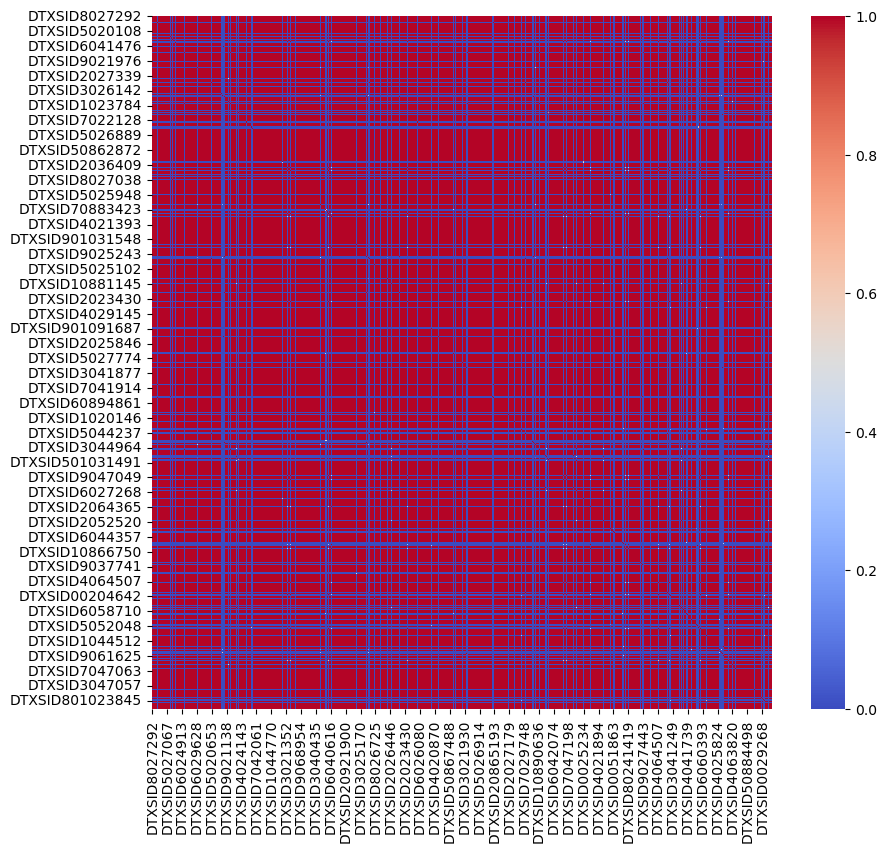

In [23]:
ft_copy = ft_copy.drop(['confidence'], axis = 1)
ft_copy = ft_copy.groupby(['endpoint', 'toxicophore']).agg(lambda x: x.sum())
ft_copy2 = ft_copy.T
# scipy
from scipy.spatial.distance import pdist, squareform
D_react = pd.DataFrame(squareform(pdist(ft_copy2, 'jaccard')), columns = ft_copy2.index, index = ft_copy2.index)
S_react = 1- D_react

plt.figure(figsize = (10,9))
sns.heatmap(S_react, cmap = 'coolwarm')

In [24]:
S_react.to_csv(processed_dir+'Sreact_reachpairs_300623.csv')

In [25]:
S_react.shape

(792, 792)